In [97]:
from pybaselines import Baseline, utils
import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, find_peaks_cwt
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid
import pandas as pd
import warnings

# Suppress pandas warnings
warnings.filterwarnings('ignore')

def get_mask_from_waves(wav_array, wav_min, wav_max):
   return (wav_array >= wav_min) * (wav_array <= wav_max)

def compute_EGO_Gaussian(lmbda, si, mu_i, sigma_i, k_i):
    # EGO Gaussian function
    return si * np.exp(-0.5 * ((lmbda - mu_i) ** 2 / (sigma_i - k_i * (lmbda - mu_i)) ** 2))

def extract_all_sheets(file_path):
    excel_file = pd.ExcelFile(file_path)
    sheet_names = excel_file.sheet_names
    
    all_data = [excel_file.parse(sheet_name, header = None) for sheet_name in sheet_names]
    
    return all_data

def get_spreadsheet_coords(df, label):
    """
    Accepts either a single label or a list
    """
    if type(label) is str:
        x_ind, y_ind = np.where(mineral_df == label)
        return x_ind[0], y_ind[0]

    elif type(label) is list:
        x_ind = []
        y_ind = []
        for list_val in label:
            x, y = np.where(mineral_df == list_val)
            x_ind.append(x[0])
            y_ind.append(y[0])
        return np.asarray(x_ind), np.asarray(y_ind)


def get_val_list(df,
                 val_name):
    # Identify how many features we have here
    start_x, start_y = get_spreadsheet_coords(df, val_name)
    val_list = []
    for i in range(start_x +1, df.shape[0]):
        curr_val = df.iloc[i , start_y]
        if i >= df.shape[0]:
            break
        elif not pd.isna(curr_val):
            val_list.append(curr_val)
        else:
            break
    
    print(f"Found {len(val_list)}: {val_list}")
    return val_list

from pybaselines import Baseline, utils
from matplotlib import pyplot as plt

class HullRemoval:
    def __init__(self,
                 x_data,
                 y_data,
                invert_data = True,
                do_plots = True):
        self.x_data = x_data
        self.y_data = y_data
        self.baseline_fitter = Baseline(x_data,
                                        check_finite=False)
        # Get the peaks of the current spectrum
        self.peaks = find_peaks(y_data,
                   width = 5)[0]
        # Append the end of the spectrum
        self.peaks = np.append(self.peaks,
                               self.y_data.shape[0]-1)
        self.do_plots = do_plots

    def get_mask_from_waves(self,
                            x_data,
                            wav_min,
                            wav_max):
       return (x_data >= wav_min) * (x_data <= wav_max)

    def interpolate_linear(self,
                           spectrum,
                           indices):
        # Create an interpolation function based on the given indices
        interp_func = interp1d(indices,
                               spectrum[indices],
                               fill_value="extrapolate")
        # Apply the interpolation function to the entire range of indices
        lower_hull = interp_func(np.arange(len(spectrum)))
        return lower_hull
    
    def calculate_baseline(self):

        # Invert the data 
        pix_inverse = 1 / self.y_data 
        
        # Calculate the baseline
        baseline_inv = self.baseline_fitter.snip(pix_inverse,
                                     max_half_window=40,
                                     decreasing=True,
                                     smooth_half_window=0)[0]
        
        # Invert the result
        self.curr_baseline = 1 / baseline_inv

        if self.do_plots:
            plt.plot(self.x_data,
                     self.y_data,
                     label='Original Spectrum')
            plt.plot(self.x_data,
                     self.curr_baseline,
                     label='Calculated Baseline')
            plt.plot(self.x_data[self.peaks],
                     self.y_data[self.peaks],
                     'o',
                     label='Peaks')
            plt.legend()
            
            plt.figure()
            plt.plot(self.x_data,
                     self.y_data/self.curr_baseline,
                     label='Hull Quotient')
            plt.legend()

    def calculate_initial_hull(self):
        prelim_hull = self.interpolate_linear(self.y_data[self.peaks[0]:],
                                              self.peaks - self.peaks[0])

        self.concat_hull = np.concatenate((self.curr_baseline[0:self.peaks[0]],
                                      prelim_hull))

        self.initial_quotient = self.y_data/self.concat_hull

        if self.do_plots:
            plt.figure()
            plt.plot(self.x_data,
                     self.y_data,
                     label='Original Spectrum')
            plt.plot(self.x_data,
                     self.concat_hull,
                     label='Hybrid Baseline')
            plt.plot(self.x_data[self.peaks],
                     self.y_data[self.peaks],
                     'o',
                     label='Peaks')
            plt.legend()
            
            plt.figure()
            plt.plot(self.x_data,
                     self.initial_quotient,
                     label='Initial Hull Quotient')
            plt.legend()

    def iterate_final_hull(self):
        curr_quotient = self.initial_quotient
        n_gt_one = (curr_quotient > 1.01).sum()
        count = 0
        while n_gt_one > 0:
            curr_index_to_add = curr_quotient.argmax()
            # Append this index to the peaks
            self.peaks = np.unique(np.sort(np.append(self.peaks,
                                                     curr_index_to_add)))
            
            
            prelim_hull = self.interpolate_linear(self.y_data[self.peaks[0]:],
                                             self.peaks - self.peaks[0])
            
            self.final_concat_hull = np.concatenate((self.curr_baseline[0:self.peaks[0]],
                                          prelim_hull))
        
            
            curr_quotient = self.y_data/self.final_concat_hull
            n_gt_one = (curr_quotient > 1).sum()
            count +=1
            if count > 20:
                print('Too many iterations, breaking loop')
                n_gt_one = -1
        if self.do_plots:
            plt.figure()
            plt.plot(self.x_data,
                     self.y_data,
                     label='Original Spectrum')
            plt.plot(self.x_data,
                     self.final_concat_hull,
                     label='Final Iterative Hull')
            plt.plot(self.x_data[self.peaks],
                     self.y_data[self.peaks],
                     'o',
                     label='Peaks')
            plt.legend()
            
            plt.figure()
            plt.plot(self.x_data,
                     curr_quotient,
                     label='Final Hull Quotient')
            plt.legend()
        self.final_quotient = curr_quotient

    def make_quotient(self):
        self.calculate_baseline()
        self.calculate_initial_hull()
        self.iterate_final_hull()
        return self.final_quotient

    def return_original_segment(self, wav_min, wav_max):
        curr_mask = self.get_mask_from_waves(self.x_data,
                                             wav_min,
                                             wav_max)
        return self.x_data[curr_mask], self.y_data[curr_mask]


def sum_of_gaussians(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

def compute_EGO_Gaussian(lmbda, si, mu_i, sigma_i, k_i):
    # EGO Gaussian function
    return si * np.exp(-0.5 * ((lmbda - mu_i) ** 2 / (sigma_i - k_i * (lmbda - mu_i)) ** 2))

def weighted_sum_EGO_Gaussians(x, *params):
    num_peaks = len(params) // 4
    result = np.zeros_like(x)
    for i in range(num_peaks):
        si, mu_i, sigma_i, k_i = params[i*4 : (i+1)*4]
        result += compute_EGO_Gaussian(x, si, mu_i, sigma_i, k_i)
    return result

def find_initial_guess(x, y, peaks):
    initial_guess = []
    for p in peaks:
        initial_guess += [0.5, x[p], 10, -0.1]
    return initial_guess

def calc_sum_EGO_Gaussians_auc_features(x, *params):
    num_peaks = len(params) // 4
    integral_list = []
    crystallinity_list = []
    
    for i in range(num_peaks):
        si, mu_i, sigma_i, k_i = params[i*4 : (i+1)*4]
        curr_y_vals = compute_EGO_Gaussian(x, si, mu_i, sigma_i, k_i)
        curr_integral = trapezoid(curr_y_vals, x)
        integral_list.append(curr_integral)
        crystallinity_list.append(si**2 / curr_integral)
    return integral_list, crystallinity_list

def get_val_list(df,
                 val_name):
    # Identify how many features we have here
    start_x, start_y = get_spreadsheet_coords(df, val_name)
    val_list = []
    for i in range(start_x +1, df.shape[0]):
        curr_val = df.iloc[i , start_y]
        if i >= df.shape[0]:
            break
        elif not pd.isna(curr_val):
            val_list.append(curr_val)
        else:
            break
    
    print(f"Found {len(val_list)}: {val_list}")
    return val_list

def parse_mineral_sheet(mineral_df):
    """
    """
    mineral_x, mineral_y = get_spreadsheet_coords(mineral_df, 'Mineral')
    
    # Identify which mineral we're parsing
    curr_mineral = mineral_df.iloc[mineral_x, mineral_y+1]
    print(f"Current mineral: {curr_mineral}")
    
    feature_list = get_val_list(mineral_df,
                                'Feature #')
    
    # Do the same thing for shapes
    region_list = get_val_list(mineral_df,
                                'Region #')
    
    # Note that this matches wrong for sheet 1 right now. 
    # we'll need to double check at a later stage of parsing
    # whether the rows have proper values or not, should be easy
    # using pd.isna
    
    # Do the same thing for shapes
    criteria_list = get_val_list(mineral_df,
                                'Criteria #')
    
    # Do the same thing for final weights
    overall_list = get_val_list(mineral_df,
                                'Overall weighting')

    return feature_list, region_list, criteria_list, overall_list, curr_mineral

def parse_feature_list(feature_list):

    # Retrieve features to include
    fx,fy = get_spreadsheet_coords(mineral_df, feature_list)
    
    feature_subset_df = mineral_df.iloc[fx, :]
    incl_features_df = feature_subset_df[feature_subset_df[1] == 'include']
    excl_features_df = feature_subset_df[feature_subset_df[1] == 'exclude']

    return incl_features_df, excl_features_df, feature_subset_df

def make_feature_dict(curr_incl_features_df):

    # Prepare the output dict
    feature_dict = {}
    
    # Loop the include features
    for incl_feature in range(curr_incl_features_df.shape[0]):
    # incl_feature = 2
        curr_feature = (curr_incl_features_df.iloc[incl_feature, :])
        curr_l_min = curr_feature[2]
        curr_l_max = curr_feature[3]
        
        curr_wav_mask = get_mask_from_waves(wav_array,
                                   curr_l_min,
                                   curr_l_max)
        
        curr_x = wav_array[curr_wav_mask]
        curr_y = curr_pixel[curr_wav_mask]
        
        # Generate the linear regression line
        x_values, y_values = generate_linear_regression(curr_x, curr_y)
        
        # Generate the continuum removed version
        curr_y_hull_ratio = curr_y/y_values
    
        
        # Do the same thing for the reference data
        curr_ref_wav_mask = get_mask_from_waves(curr_ref.Wavelength,
                                   curr_l_min,
                                   curr_l_max)
        
        curr_ref_x = curr_ref.Wavelength[curr_ref_wav_mask]
        curr_ref_y = curr_ref.Reflectance[curr_ref_wav_mask]
        
        
        # Generate the linear regression line
        x_ref_values, y_ref_values = generate_linear_regression(curr_ref_x.values, 
                                                                curr_ref_y.values)
        
        # Generate the continuum removed version
        curr_ref_y_hull_ratio = curr_ref_y/y_ref_values
    
        # Build the dict for the current feature
        curr_feat_dict = {}
        curr_feat_dict['spec_subset_x'] = curr_x
        curr_feat_dict['spec_subset_y'] = curr_y
        curr_feat_dict['spec_regression_x'] = x_values
        curr_feat_dict['spec_reggression_y'] = y_values
        curr_feat_dict['spec_hull_removed'] = curr_y_hull_ratio
        # Add the same features for the reference
        curr_feat_dict['ref_subset_x'] = curr_ref_x
        curr_feat_dict['ref_subset_y'] = curr_ref_y
        curr_feat_dict['ref_regression_x'] = x_ref_values
        curr_feat_dict['ref_reggression_y'] = y_ref_values
        curr_feat_dict['ref_hull_removed'] = curr_ref_y_hull_ratio    
        # Store all of this for the current feature
        this_feat_name = str(incl_feature) + '_' + curr_feature[0]
        feature_dict[this_feat_name] = curr_feat_dict

    return feature_dict

def do_tetracorder_weighting(curr_feat_dict, curr_ref_y_hull_ratio):
    
    for i, feat_name in enumerate(curr_feat_dict):
    # i = 0
    # this_feat = curr_feat_dict[list(curr_feat_dict.keys())[0]]
        this_feat = curr_feat_dict[feat_name]
        # Retrieve the variables we need locally
        spec_hull_ratio = this_feat['spec_hull_removed']
        ref_hull_ratio = this_feat['ref_hull_removed']
        ref_subset_x = this_feat['ref_subset_x']
        curr_ref_y_hull_ratio = this_feat['ref_hull_removed']
        
        # Get the minimum length between the reference and spectrum
        # to interpolate to
        min_length = np.min((len(spec_hull_ratio), len(ref_hull_ratio)))
        
        # Interpolate for regression
        ref_y_hull_ratio_downsampled = np.interp(np.linspace(0, len(curr_ref_y_hull_ratio) - 1, min_length),
                                            np.arange(len(curr_ref_y_hull_ratio)), curr_ref_y_hull_ratio)
        
        # Fit the least squares
        a, b, k, F = perform_least_squares_fit(spec_hull_ratio,
                                               ref_y_hull_ratio_downsampled)
        
        # store F
        this_feat['F'] = F
    
        #TODO this isn't very efficient as noted in tetracorder this should happen before all other calculations so that it doesn't have to happen every spsectrum
        # Store AUC
        this_feat['AUC'] = trapezoid(ref_hull_ratio, ref_subset_x)
    
        # Store depth
        this_feat['ref_depth'] = ref_hull_ratio.min()
        this_feat['spec_depth'] = spec_hull_ratio.min()
    
        # Update the main dict
        curr_feat_dict[list(curr_feat_dict.keys())[i]] = this_feat
    
    # Loop through again and calculate the overall weighting
    area_array = np.empty(len(curr_feat_dict))
    fits_array = np.empty(len(curr_feat_dict))
    depth_array = np.empty(len(curr_feat_dict))
    
    for i, feat_name in enumerate(curr_feat_dict):
        this_feat = curr_feat_dict[feat_name]
        area_array[i] = this_feat['AUC']
        # Extract the Fit variable
        fits_array[i] = this_feat['F']
        # Extract the Depeth variable
        depth_array[i] = this_feat['spec_depth']
    
    
    area_weights = area_array / area_array.sum()
    
    weighted_fits = (fits_array * area_weights).sum()
    weighted_depths = (depth_array * area_weights).sum()
    weighted_fit_x_depth =  (fits_array * depth_array * area_weights).sum()

    return weighted_fits, weighted_depths, weighted_fit_x_depth, area_weights

# At the bandmath stage we're going to need to calculate all available parameters
# Kaolinite crystallinity index	Kx	R 2180/R2166
# Illite spectral maturity	ISM	D(F-2200)/D(F-1900)
# Iron slope	Fe_slope	R1650/R1350
# Aspectral slope	Asp_slope	R1450/R1850
# Albedo	Albedo	Average R1550:1750
# opaque index	Opi	Average R (520:600/1600:1700)
# Fe2+ index	Fe2	(R920+R1650)/(R1020+R1235)

def calc_kx(x_data, y_data):
    # Kaolinite crystallinity index	Kx	R 2180/R2166
    # Get the index of where we are
    ind_2166 = np.searchsorted(x_data, 2166)
    ind_2180 = np.searchsorted(x_data, 2180)
    return y_data[ind_2180] /  y_data[ind_2166]

def calc_fe_slope(x_data, y_data):
    # Iron slope	Fe_slope	R1650/R1350
    # Get the index of where we are
    ind_1650 = np.searchsorted(x_data, 1650)
    ind_1350 = np.searchsorted(x_data, 1350)
    return y_data[ind_1650] /  y_data[ind_1350]

def calc_asp_slope(x_data, y_data):
    # Aspectral slope	Asp_slope	R1450/R1850
    # Get the index of where we are
    ind_1450 = np.searchsorted(x_data, 1450)
    ind_1850 = np.searchsorted(x_data, 1850)
    return y_data[ind_1450] /  y_data[ind_1850]

def calc_arbitrary_ref_ratio(x_data,
                             y_data,
                             ref1_val,
                             ref2_val):
    ind_ref1 = np.searchsorted(x_data, ref1_val)
    ind_ref2 = np.searchsorted(x_data, ref2_val)
    return y_data[ind_ref1] /  y_data[ind_ref2]  

def min_max_normalization(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def cosine_similarity(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))




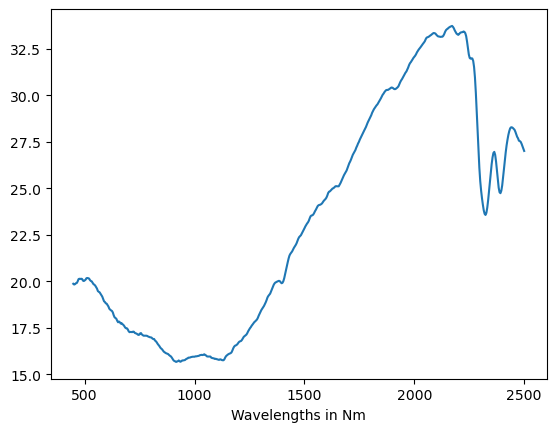

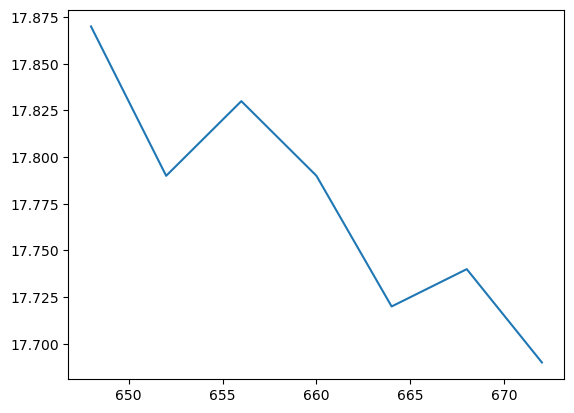

In [104]:
# Input a spectrum 

ref_data = pd.read_csv('reference_lib/Amphibole_03.csv')
wav_array = ref_data.iloc[:,0].values
curr_pixel =  ref_data.iloc[:,1].values

plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelengths in ' + 'Nm')

# Master peak ranges
# This data will need to be committed to a database table so that it can be extracted
# in a more easily edited central location
min_list = np.sort(np.asarray([820, 2490, 645, 790, 880, 1370, 1450, 1465, 1535, 1710, 1890, 1935, 2145, 2185, 2230, 2220, 2270, 2325, 2345, 2375]))
max_list = np.sort(np.asarray([980, 2550, 675, 810, 1150, 1420, 1490, 1500, 1565, 1785, 1940, 1960, 2185, 2230, 2265, 2300, 2330, 2370, 2390, 2415]))
mineral_label = ['iron oxides (goethite, hematite)', 'carbonates', 'molybdenite', 
                 'REE', 'pyroxene', 'micas, clays', 'jarosite', 'alunite', 
                 'epidote', 'sulphates', 'all OH, zeo', 'gypsum',
                 'pyrophyllite', 'Al-OH', 'chlorite, biotite', 'Al-fe smectites', 
                 'Fe-Mg smectites', 'chlorite, biotite', 'tourmaline', 'amphiboles, biotite']
hull_correct_bool = [False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]

# Load the master list directly
feature_master_file = 'master_list.xlsx'
feature_master_df = pd.read_excel(feature_master_file)

l1, l2 = hull_removal.return_original_segment(min_list[0], max_list[0])
plt.figure()
plt.plot(l1, l2)

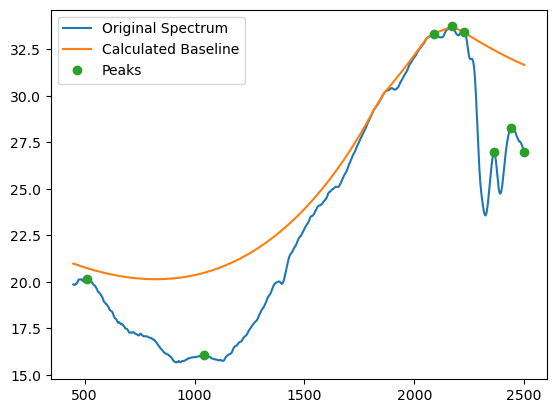

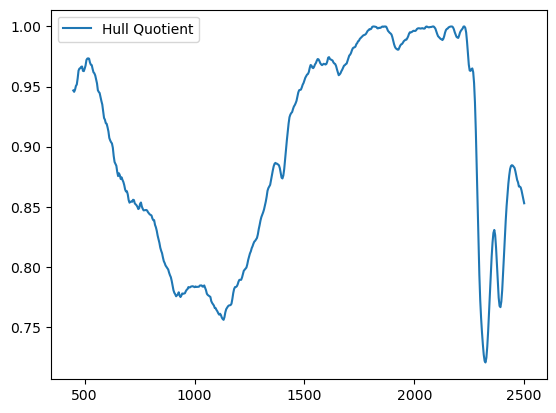

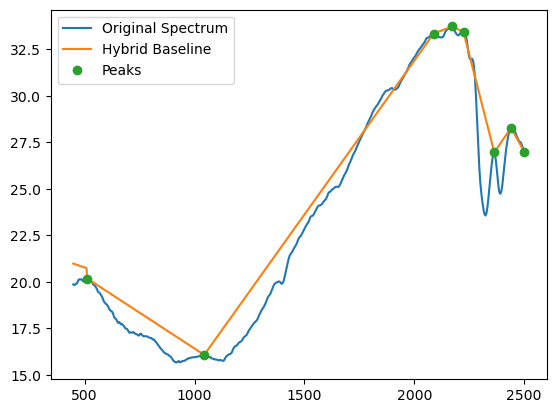

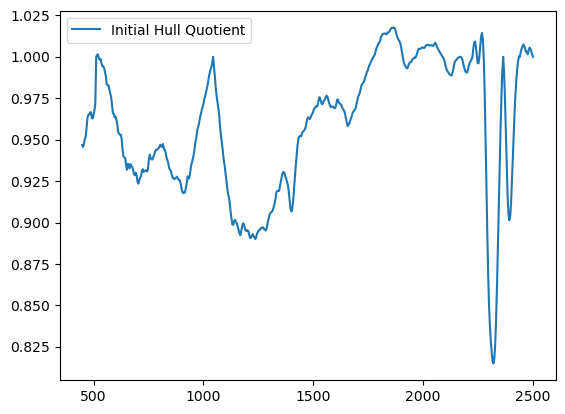

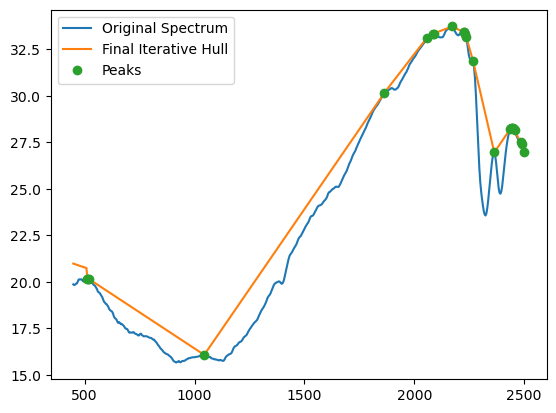

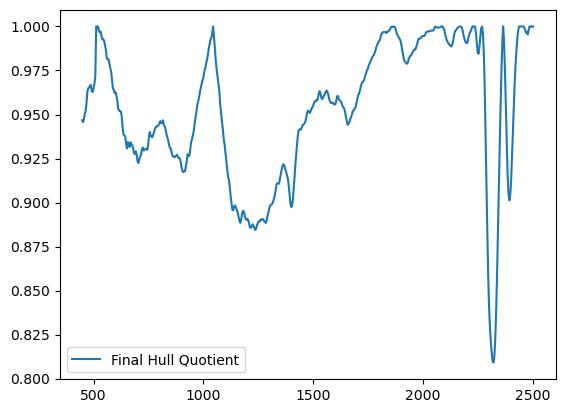

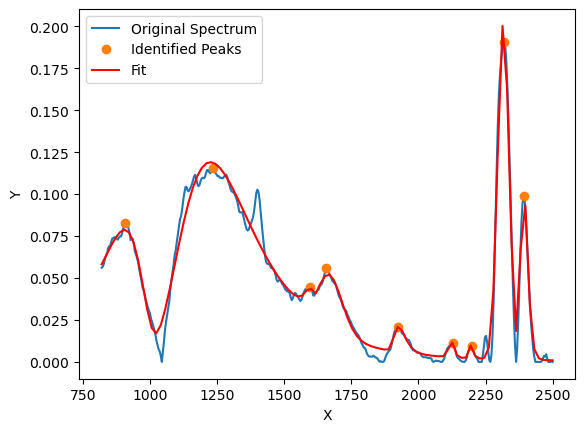

In [99]:
# Remove the hull iteratively 

hull_removal = HullRemoval(wav_array, curr_pixel, do_plots = True)
curr_quotient = hull_removal.make_quotient()

# Get the entire spectrum in the range where we care about the peaks

curr_start = min_list[hull_correct_bool].min()
curr_stop  = max_list[hull_correct_bool].max()

curr_mask = get_mask_from_waves(wav_array,
                                curr_start,
                                curr_stop)

curr_wavs = wav_array[curr_mask]
curr_peaks = 1-curr_quotient[curr_mask]

fit_peaks = find_peaks(curr_peaks, width = 6)[0]
plt.figure()
plt.plot(curr_wavs, curr_peaks, label = 'Original Spectrum')
plt.plot(curr_wavs[fit_peaks], curr_peaks[fit_peaks], 'o', label = 'Identified Peaks')


# Find initial guess for the parameters
initial_guess = find_initial_guess(curr_wavs, curr_peaks, fit_peaks)

# Fit the weighted sum of EGO Gaussians to the data
params, _ = curve_fit(weighted_sum_EGO_Gaussians,
                      curr_wavs,
                      curr_peaks,
                      p0=initial_guess)

# Generate x-values for plotting the fitted curve
x_values = np.linspace(min(curr_wavs), max(curr_wavs), 100)

# Generate y-values for the fitted curve using the obtained parameters
y_values = weighted_sum_EGO_Gaussians(x_values, *params)

# Plot the original data and the fitted curve
# plt.plot(curr_wavs, curr_peaks)
plt.plot(x_values, y_values, 'r-', label='Fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [91]:
# Prepare our output dictionary
outputs = {}
# And a place to store simplified results
result_list = []
result_table = pd.DataFrame(columns = ['Overall Match', 'Feature Match', 'Region Match', 'Band Math Match'])

# Let's start by ingesting the criteria we've gotten from Cari
ref_lib_data = extract_all_sheets('Ref Library match criteria v2.xls')

# Make a nicely filled out dataframe of all our current features 
fit_df = pd.DataFrame([params[i*4:((i*4)+4)] for i in range(len(fit_peaks))],
             columns = ['Amplitude', 'Center', 'Width', 'Asymmetry'])
fit_df['FWHM'] = fit_df.Width * 2.35482

auc_by_peak, crystallinity_by_peak = calc_sum_EGO_Gaussians_auc_features(x_values, *params)
fit_df['Area'] = auc_by_peak
fit_df['Crystallinity'] = crystallinity_by_peak
display(fit_df)

# Get the features that we have currently in range
feature_master_df.dropna(inplace=True)

# Let's look at a single example to start with
# for mineral_df in ref_lib_data[1:-2]:
mineral_df = ref_lib_data[1]
fit_df['FeatureID'] = ''
fit_df['Include/Exclude'] = ''
fit_df['Weight'] = ''
fit_df['WidthMatch'] = ''
fit_df['AmpMatch'] = ''
fit_df['AsymmMatch'] = ''

curr_feat_list, curr_region_list, curr_crit_list, curr_overall_list, curr_mineral_name = parse_mineral_sheet(mineral_df)
curr_incl_features_df, curr_excl_features_df, feature_subset_df = parse_feature_list(curr_feat_list)

# Reset the column names for these dataframes
curr_incl_features_df.columns = ['Feature #',	'Include/Exclude',	'L min', 'L max', 'Wmin', 	'Wmax', 	'Hmin%', 	'Hmax%', 	'ASmin', 	'ASmax', 	'Smooth?', 'Weight']
curr_excl_features_df.columns = ['Feature #',	'Include/Exclude',	'L min', 'L max', 'Wmin', 	'Wmax', 	'Hmin%', 	'Hmax%', 	'ASmin', 	'ASmax', 	'Smooth?', 'Weight']
feature_subset_df.columns = ['Feature #',	'Include/Exclude',	'L min', 'L max', 'Wmin', 	'Wmax', 	'Hmin%', 	'Hmax%', 	'ASmin', 	'ASmax', 	'Smooth?', 'Weight']

# Iterate the fit df centers for whether we're in range
# [True for i, curr_center in enumerate(fit_df.Center) if 10000 <= curr_center <= feature_master_df['Minima To'][i]:
# curr_center = fit_df.Center[0]
# We need to iterate each of the features and see if they exist in the current fits
matched_features_list = []
matched_features_temp_list = []
for i,k in enumerate(fit_df.Center):
    for ii, feature in enumerate(feature_master_df['Product ID']):
        # print(feature_master_df['Minima From'].iloc[ii])
        # feature_master_df['Minima To'].iloc[ii]
        curr_range = (feature_master_df['Minima From'].iloc[ii], feature_master_df['Minima To'].iloc[ii])
        if curr_range[0] <= k <= curr_range[1]:
            # matched_features_list.append(feature)
            fit_df['FeatureID'].iloc[i] = feature
            # Identify if this is an include or exclude 
            if feature in curr_incl_features_df['Feature #'].to_list():
                fit_df['Include/Exclude'].iloc[i] = 'Include'
            if feature in curr_excl_features_df['Feature #'].to_list():
                fit_df['Include/Exclude'].iloc[i] = 'Exclude'
                               
            # Check the other features now that we've identified we're in the right range
            # Dataframe of current feature criteria
            curr_feat_df = feature_subset_df[feature_subset_df['Feature #'] == feature]

            # Make sure we only operate on filled out datasets
            if len(curr_feat_df) > 0:
                # Width
                curr_width_range = (curr_feat_df['Wmin'].values[0],
                                    curr_feat_df['Wmax'].values[0])
                if curr_width_range[0] <= fit_df['FWHM'][i] <= curr_width_range[1]:
                    fit_df['WidthMatch'].iloc[i] = 'X'
                
                # Amplitude
                # Note that input criteria are in percent (1-100) and we fit
                # 0-1 range. Here we handle that conversion
                curr_amp_range = (curr_feat_df['Hmin%'].values[0] / 100,
                                    curr_feat_df['Hmax%'].values[0] / 100)
                if curr_amp_range[0] <= fit_df['Amplitude'][i] <= curr_amp_range[1]:
                    fit_df['AmpMatch'].iloc[i] = 'X'

                # Asymmetry placeholder
                # We're not really using these yet, lets pretend like they're matches for now
                # so we can do other math properly 
                curr_asymm_range = (curr_feat_df['ASmin'].values[0],
                                    curr_feat_df['ASmax'].values[0])
                # if curr_asymm_range[0] <= fit_df['Amplitude'][i] <= curr_asymm_range[1]:
                fit_df['AsymmMatch'].iloc[i] = 'X'

                # Add the weighting to us
                fit_df['Weight'].iloc[i] = curr_feat_df['Weight'].values[0]


,Amplitude,Center,Width,Asymmetry,FWHM,Area,Crystallinity
0,0.078605,905.314511,83.645529,0.302116,196.970165,11.664759,0.000530
1,0.118770,1224.953360,138.326743,-0.210216,325.734581,48.031154,0.000294
2,0.009784,1590.803398,16.819620,0.330973,39.607178,0.813741,0.000118
3,0.033028,1669.942028,45.611464,-0.028859,107.406789,3.785637,0.000288
4,0.015235,1926.843924,20.794417,-0.150707,48.967109,0.855595,0.000271
5,0.009080,2123.646987,11.090031,0.029958,26.115027,0.253263,0.000326
6,0.007793,2196.462751,8.050727,-0.026030,18.958013,0.161521,0.000376
7,0.200932,2316.456424,20.896159,-0.002582,49.206694,10.524787,0.003836
8,0.101282,2392.291260,12.855117,-0.103358,30.271486,3.378872,0.003036


Current mineral: Amphibole
Found 4: ['F-2300', 'F-2380', 'F-2250', 'other']
Found 1: ['R1']
Found 2: ['C1', 'C2']
Found 3: ['Features', 'Shape', 'Band Math']


In [45]:
fx,fy = get_spreadsheet_coords(mineral_df, curr_crit_list)
bandmath_subset_df = mineral_df.iloc[fx, :]
# Clean the dataframe of extra columns - this causes more trouble than it's worth for now
# bandmath_subset_df.dropna(axis = 1, how = 'all', inplace = True)
# Update the columns
bandmath_subset_df.columns = ['Criteria #',	'Feature or R',	'parameter', 'equation',	'Feature or value',	'parameter',	'Weight', 7, 8, 9, 10, 11]
# Add a result column
bandmath_subset_df['comparison_result'] = False
bandmath_subset_df['comparison_value'] = ''


# Loop the criteria to parse them out
for i in range(len(bandmath_subset_df)):
    # This is going to be an ugly parser, we'll rebuild it someday
    # Successfully parses the 1st amphibole feature
    if bandmath_subset_df.iloc[i,:]['Feature or R'] in curr_feat_list:
        if bandmath_subset_df['parameter'].iloc[i, 0] == 'depth':
            # This seems to always mean we've got a set of 2 features to compare, 
            # for now we'll assume that to be so
            # Calculate both features
            feat1 = fit_df[fit_df.FeatureID == bandmath_subset_df.iloc[i,:]['Feature or R'].strip()]
            feat2 = fit_df[fit_df.FeatureID == bandmath_subset_df.iloc[i,:]['Feature or value'].strip()]
            # Save both features for diagnostics regardless of what happens later
            bandmath_subset_df['comparison_value'].iloc[i] = [np.round(feat1.Amplitude.values[0], 4),
                                                  np.round(feat2.Amplitude.values[0], 4)]
            # Greater than
            if bandmath_subset_df.iloc[i,:]['equation'] == '>':
                if feat1.Amplitude.values[0] > feat2.Amplitude.values[0]:
                    bandmath_subset_df['comparison_result'].iloc[i] = True
            # Less than
            if bandmath_subset_df.iloc[i,:]['equation'] == '<':
                if feat1.Amplitude.values[0] < feat2.Amplitude.values[0]:
                    bandmath_subset_df['comparison_result'].iloc[i] = True

    if bandmath_subset_df.iloc[i,:]['Feature or R'] == 'Fe-slope':
        curr_fe_slope = calc_fe_slope(curr_wavs, curr_peaks)
        bandmath_subset_df['comparison_value'].iloc[i] = curr_fe_slope
        if bandmath_subset_df.iloc[i,:]['equation'] == '>':
            if curr_fe_slope > bandmath_subset_df.iloc[i,:]['Feature or value']:
                bandmath_subset_df['comparison_result'].iloc[i] = True
        if bandmath_subset_df.iloc[i,:]['equation'] == '<':
            if curr_fe_slope < bandmath_subset_df.iloc[i,:]['Feature or value']:
                bandmath_subset_df['comparison_result'].iloc[i] = True

    if bandmath_subset_df.iloc[i,:]['Feature or R'] == 'Asp-slope':
        curr_asp_slope = calc_asp_slope(curr_wavs, curr_peaks)
        bandmath_subset_df['comparison_value'].iloc[i] = curr_asp_slope
        # Greater than
        if bandmath_subset_df.iloc[i,:]['equation'] == '>':
            if curr_asp_slope > bandmath_subset_df.iloc[i,:]['Feature or value']:
                bandmath_subset_df['comparison_result'].iloc[i] = True
        # Less than
        if bandmath_subset_df.iloc[i,:]['equation'] == '<':
            if curr_asp_slope < bandmath_subset_df.iloc[i,:]['Feature or value']:
                bandmath_subset_df['comparison_result'].iloc[i] = True

    if len(bandmath_subset_df.iloc[i,:]['Feature or R'].split('/')) > 1:
        curr_comparison_list = bandmath_subset_df.iloc[i,:]['Feature or R'].split('/')
        # Get the value we need to compare at 
        crit0 = curr_comparison_list[0][1:]
        crit1 = curr_comparison_list[1][1:]
        
        ref_ratio = calc_arbitrary_ref_ratio(curr_wavs,
                                             curr_peaks,
                                             int(crit0),
                                             int(crit1))
        bandmath_subset_df['comparison_value'].iloc[i] = ref_ratio
        # Greater than
        if bandmath_subset_df.iloc[i,:]['equation'].strip() == '>':
            if ref_ratio > float(bandmath_subset_df.iloc[i,:]['Feature or value']):
                bandmath_subset_df['comparison_result'].iloc[i] = True
        # Less than
        if bandmath_subset_df.iloc[i,:]['equation'].strip() == '<':
            if ref_ratio < float(bandmath_subset_df.iloc[i,:]['Feature or value']):
                bandmath_subset_df['comparison_result'].iloc[i] = True

    # Treat cases where we have a single reflectance comparison set
    if bandmath_subset_df.iloc[i,:]['Feature or R'][0] == 'R':
        ref_value = int(bandmath_subset_df.iloc[i,:]['Feature or R'][1:])
        bandmath_subset_df['comparison_value'].iloc[i] = ref_value

        if bandmath_subset_df.iloc[i,:]['equation'].strip() == '>':
            if ref_value > float(bandmath_subset_df.iloc[i,:]['Feature or value']):
                bandmath_subset_df['comparison_result'].iloc[i] = True
        if bandmath_subset_df.iloc[i,:]['equation'].strip() == '=<':
            if ref_value < float(bandmath_subset_df.iloc[i,:]['Feature or value']):
                bandmath_subset_df['comparison_result'].iloc[i] = True


In [52]:
fx,fy = [], []
fx,fy = get_spreadsheet_coords(mineral_df, curr_region_list)
region_subset_df = mineral_df.iloc[fx, :]
region_subset_df.columns = ['Region #',	'L min',	'L max',	'or',	'Feature',	'Smooth?',	'Weight', 8, 9, 10, 11, 12]
region_subset_df['CosSimilarity'] = ''

for i in range(len(region_subset_df)):
# i = 0 
    curr_min = region_subset_df.iloc[i,:]['L min']
    curr_max = region_subset_df.iloc[i,:]['L max']
    curr_mask = get_mask_from_waves(curr_wavs, curr_min, curr_max)
    curr_region = curr_peaks[curr_mask]

    #TODO needs to be worked in v4, not currently inputting refs *and* comparison data
    noise = np.random.normal(0,0.01,len(curr_region)) + 0.1
    curr_reference_region = curr_region + noise
    
    curr_region_normalized = min_max_normalization(curr_region)
    curr_reference_region_normalized = min_max_normalization(curr_reference_region)
    
    cos_sim = cosine_similarity(curr_region_normalized, curr_reference_region_normalized)
    
    region_subset_df['CosSimilarity'].iloc[i] = cos_sim

In [58]:
# Final weighting needs to be performed for a combined metric

curr_overall_list
fx,fy = [], []
fx,fy = get_spreadsheet_coords(mineral_df, curr_overall_list)
overall_subset_df = mineral_df.iloc[fx, :]
# overall_subset_df.columns = ['Region #',	'L min',	'L max',	'or',	'Feature',	'Smooth?',	'Weight', 8, 9, 10, 11, 12]
# This may be too agressive, but we could clean this up to just the weighting values in 2 columns if not
overall_subset_df.dropna(axis = 1, how = 'all', inplace= True)
feat_weight = overall_subset_df.iloc[0,1]
shape_weight = overall_subset_df.iloc[1,1]
band_weight = overall_subset_df.iloc[1,1]

# Total feature by weight
weight_total = curr_incl_features_df.Weight.sum() + curr_excl_features_df.Weight.sum()
# Existing include features identified
incl_features_sum = fit_df[fit_df['Include/Exclude'] == 'Include'].Weight.sum()
# How many exclude features do we have? We subtract identified excludes as they shouldn't be there
excl_features_sum = curr_excl_features_df['Weight'].sum() - fit_df[fit_df['Include/Exclude'] == 'Exclude'].Weight.sum()
# Take a sum of include and exclude for this, weighted by our sum of weights
feature_match_perc = (incl_features_sum + excl_features_sum) / weight_total
print(f"Identified a feature match of {feature_match_perc * 100} percent to the identified features")
display(fit_df)
display(curr_incl_features_df)
display(curr_excl_features_df)
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")

# Calculate the weighted match
# Total feature by weight
weight_total = []
weight_total = bandmath_subset_df.Weight.sum()

# Take a sum of include and exclude for this, weighted by our sum of weights
bandmath_match_perc = (bandmath_subset_df.comparison_result * bandmath_subset_df.Weight).sum() / weight_total
display(bandmath_subset_df)
print(f"Identified a band math match of {bandmath_match_perc * 100} percent to the identified features")
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")

# Calculate the weighted match
# Total feature by weight
weight_total = []
weight_total = region_subset_df.Weight.sum()

# Take a sum of include and exclude for this, weighted by our sum of weights
if (region_subset_df.CosSimilarity < 0).sum() > 0:
    print("FOUND COS SIMILARITY OF LESS THAN 0, MATH MAY BE WRONG BELOW")
region_match_perc = region_subset_df.CosSimilarity.sum() / weight_total
display(region_subset_df)
print(f"Identified a regional shape match of {region_match_perc * 100} percent to the identified features")
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")

# Final weighting

# Fill Na values with 1s for now, ask Cari about what they should be in the future
overall_subset_df.fillna(1, inplace = True)
overall_subset_df.columns=['CategoryName', 'Weight']
overall_subset_df['CategoryValue'] = ''



# Add each important category in turn if we have any data for them
if len(feature_subset_df) > 0:
    overall_subset_df['CategoryValue'].iloc[0] = feature_match_perc
if len(region_subset_df) > 0:
    overall_subset_df['CategoryValue'].iloc[1] = region_match_perc
if len(bandmath_subset_df) > 0:
    overall_subset_df['CategoryValue'].iloc[2] = bandmath_match_perc

# Calculate the weighted match
# Total feature by weight
weight_total = []
weight_total = overall_subset_df.Weight.sum()

# Take a sum of include and exclude for this, weighted by our sum of weights
overall_match_perc = (overall_subset_df['CategoryValue'] * overall_subset_df['Weight']).sum() / overall_subset_df['Weight'].sum()
print(f"Identified an overall match of {overall_match_perc * 100} percent to the identified features")
display(overall_subset_df)
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")

Identified a feature match of 100.0 percent to the identified features


,Amplitude,Center,Width,Asymmetry,FWHM,Area,Crystallinity,FeatureID,Include/Exclude,Weight,WidthMatch,AmpMatch,AsymmMatch
0,0.078605,905.314511,83.645529,0.302116,196.970165,11.664759,0.000530,F-1000,,,,,
1,0.118770,1224.953360,138.326743,-0.210216,325.734581,48.031154,0.000294,,,,,,
2,0.009784,1590.803398,16.819620,0.330973,39.607178,0.813741,0.000118,,,,,,
3,0.033028,1669.942028,45.611464,-0.028859,107.406789,3.785637,0.000288,,,,,,
4,0.015235,1926.843924,20.794417,-0.150707,48.967109,0.855595,0.000271,F-1900,,,,,
5,0.009080,2123.646987,11.090031,0.029958,26.115027,0.253263,0.000326,,,,,,
6,0.007793,2196.462751,8.050727,-0.026030,18.958013,0.161521,0.000376,F-2200,,,,,
7,0.200932,2316.456424,20.896159,-0.002582,49.206694,10.524787,0.003836,F-2300,Include,3,X,X,X
8,0.101282,2392.291260,12.855117,-0.103358,30.271486,3.378872,0.003036,F-2380,Include,3,X,X,X


,Feature #,Include/Exclude,L min,L max,Wmin,Wmax,Hmin%,Hmax%,ASmin,ASmax,Smooth?,Weight
4,F-2300,include,2300,2335,15,250,3,100,NaN,NaN,low,3
5,F-2380,include,2385,2425,15,250,3,100,NaN,NaN,low,3


,Feature #,Include/Exclude,L min,L max,Wmin,Wmax,Hmin%,Hmax%,ASmin,ASmax,Smooth?,Weight
6,F-2250,exclude,2230,2255,5,125,5,50,NaN,NaN,low,1
7,other,exclude,2070,2100,5,100,5,25,NaN,NaN,low,1


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,Criteria #,Feature or R,parameter,equation,Feature or value,parameter,Weight,7,8,9,10,11,comparison_result,comparison_value
24,C1,F-2300,depth,>,F-2380,depth,2,NaN,NaN,NaN,NaN,NaN,True,"[0.2009, 0.1013]"
25,C2,Fe-slope,NaN,>,1,NaN,1,NaN,NaN,NaN,NaN,NaN,False,0.636997


Identified a band math match of 66.66666666666666 percent to the identified features
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,Region #,L min,L max,or,Feature,Smooth?,Weight,8,9,10,11,12,CosSimilarity
16,R1,2290,2430,NaN,NaN,med,1,NaN,NaN,NaN,NaN,NaN,0.992501


Identified a regional shape match of 99.25006289677525 percent to the identified features
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Identified an overall match of 91.47918239086047 percent to the identified features


,CategoryName,Weight,CategoryValue
35,Features,2,1.0
36,Shape,1,0.992501
22,Band Math,1,0.666667


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [93]:

curr_min_dict = {}
curr_min_dict['Features'] = fit_df
curr_min_dict['Shape'] = region_subset_df
curr_min_dict['Bandmath'] = bandmath_subset_df
curr_min_dict['Overall'] = overall_subset_df
curr_min_dict['OverallMatchPercent'] = overall_match_perc
curr_min_dict['FeatureMatchPercent'] = feature_match_perc
curr_min_dict['ShapeMatchValue'] = region_match_perc
curr_min_dict['BandmathMatchPercent'] = bandmath_match_perc

curr_match_list = [overall_match_perc, feature_match_perc, region_match_perc, bandmath_match_perc]

result_list.append(curr_match_list)
outputs[curr_mineral_name] = curr_min_dict

,0,1,2,3
0,0.914792,1.0,0.992501,0.666667
1,0.914792,1.0,0.992501,0.666667
